First of all, to encode Sudoku problem into the quantum setting, we need to define each cell. In the $2 \times 2$ Sudoku toy example,each cell is characterized by 2 qubits:$$ 0 \mapsto |00\rangle, 1 \mapsto |01\rangle, 2 \mapsto |10\rangle, 3 \mapsto |11\rangle,$$

A $n^2 \times n^2$ Sudoku problem is defined by 3 conditions: 
        
        1. Every row has numbers range from 1 to n that are all different.
        2. Every column has numbers range from 1 to n that are all different.
        3. Each $n \times n$ sub-block has numbers range from 1 to n that are all different.

The idea is to use 2 ancilla to compare 2 qubits in each cell. If one is different, then the corresponding cell is different. So we mark it using an extra ancilla in the accumulate_difference function. Finally, if all pairs are different we use 1 final qubit to change the phase of the targeted solution.

Now we first biuld up a row_oracle to achieve the first condition and the rest 2 conditions will follow similarly and visualize it using a single row.
        

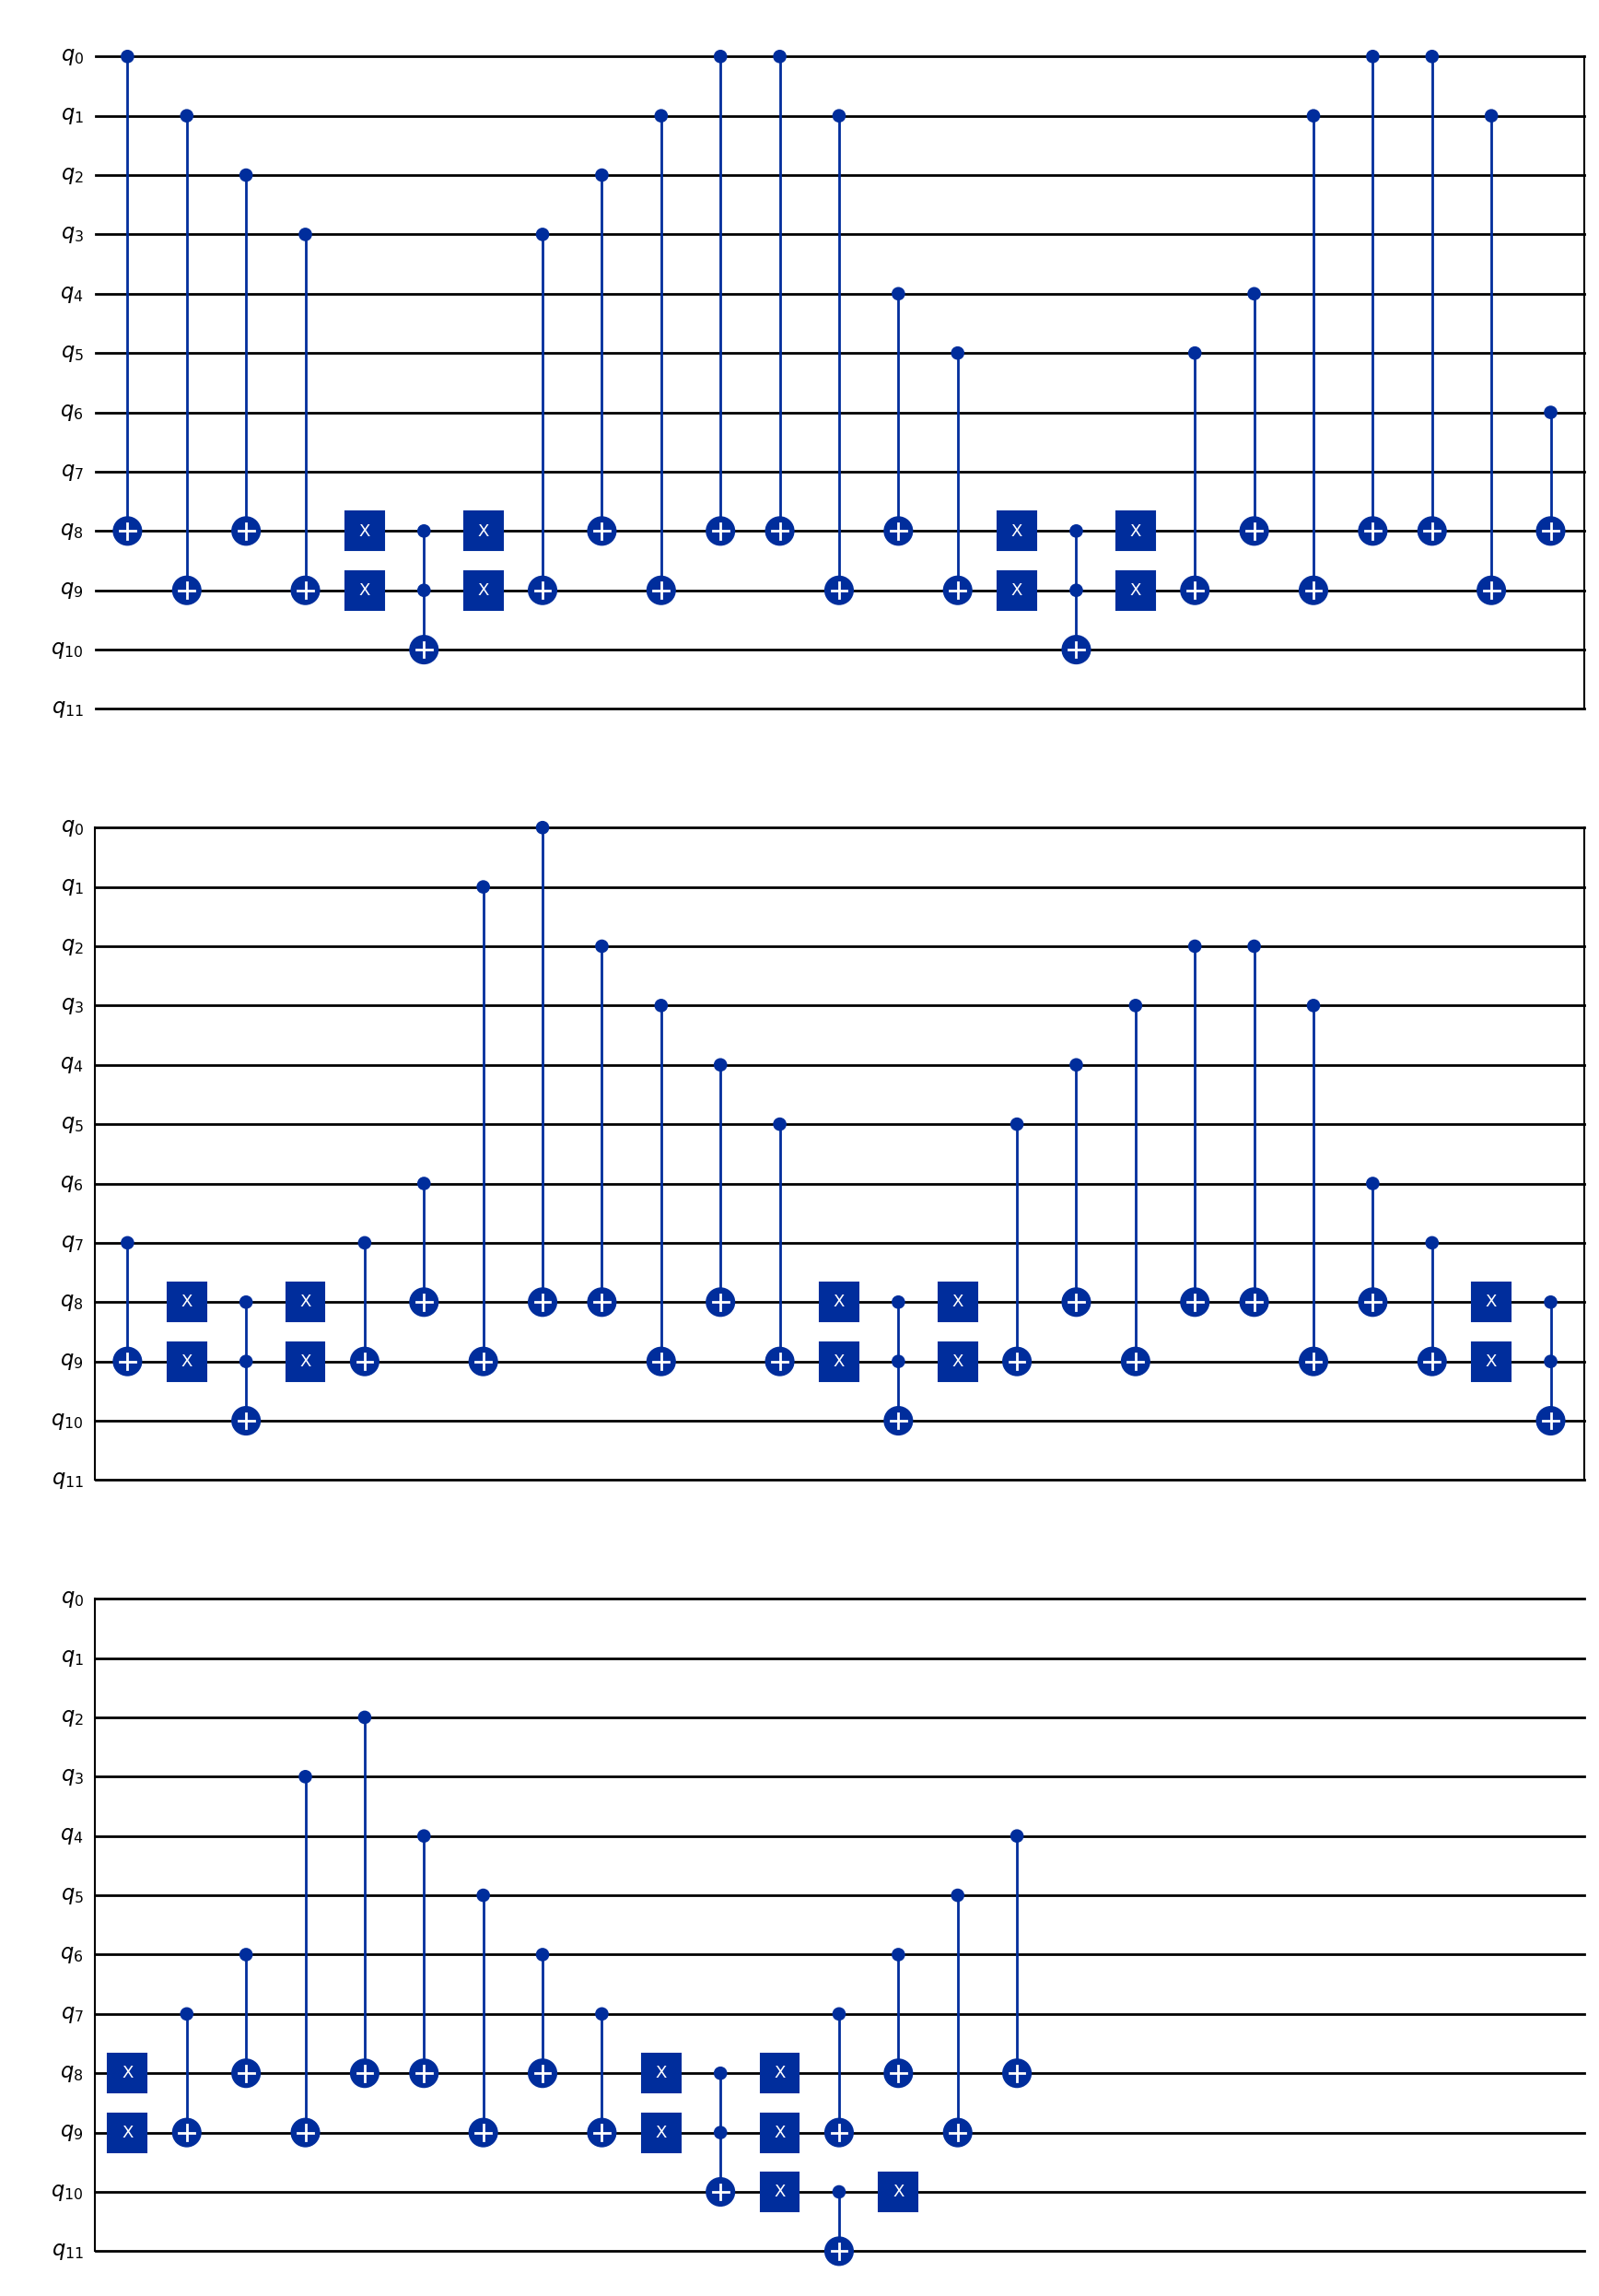

In [2]:
qc = QuantumCircuit(12)
data = [qc.qubits[i] for i in range(8)]
anc = [qc.qubits[8], qc.qubits[9]]
acc = qc.qubits[10]
flag = qc.qubits[11]

def compare_cells(qc, q1, q2, anc):
    qc.cx(q1[0], anc[0])
    qc.cx(q2[0], anc[0])
    qc.cx(q1[1], anc[1])
    qc.cx(q2[1], anc[1])

def accumulate_difference(qc, anc, acc):
    qc.x(anc[0])
    qc.x(anc[1])
    qc.ccx(anc[0], anc[1], acc)
    qc.x(anc[0])
    qc.x(anc[1])

def uncompute_compare(qc, q1, q2, anc):
    qc.cx(q2[1], anc[1])
    qc.cx(q1[1], anc[1])
    qc.cx(q2[0], anc[0])
    qc.cx(q1[0], anc[0])

from itertools import combinations

def one_row_oracle(qc, data, anc, acc, flag):
    cells = [data[i:i+2] for i in range(0, 8, 2)]
    for i, j in combinations(range(4), 2):
        compare_cells(qc, cells[i], cells[j], anc)
        accumulate_difference(qc, anc, acc)
        uncompute_compare(qc, cells[i], cells[j], anc)
    qc.x(acc)
    qc.cx(acc, flag)
    qc.x(acc)

one_row_oracle(qc, data, anc, acc, flag)
qc.draw("mpl")  # or qc.draw("text")


Now we are ready to biuld the complete Grover algorithm:
        
        1. Prepare

$$
|s\rangle = \cos\left(\frac{\theta}{2}\right)|w^\perp\rangle + \sin\left(\frac{\theta}{2}\right)|w\rangle
, \sin\left(\frac{\theta}{2}\right)= \frac{1}{\sqrt{2^n}}$$

        2. Apply oracle
$$
U_f = \mathbb{I} - 2 |w\rangle \langle w| $$ to $|s\rangle$ which is in fact a reflection at $|w^\perp\rangle$

        3. Apply diffusor
$$ 
V = 2 |s\rangle \langle s| - \mathbb{I}$$ which is a refelction at $|s \rangle$.
   
The following is the full algorithm that needs to be applied to a real Sudoku later. 

In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import MCXGate
from itertools import combinations

# --- Comparison logic ---

def compare_cells(qc, q1, q2, anc):
    qc.cx(q1[0], anc[0])
    qc.cx(q2[0], anc[0])
    qc.cx(q1[1], anc[1])
    qc.cx(q2[1], anc[1])

def accumulate_difference(qc, anc, acc):
    qc.x(anc[0])
    qc.x(anc[1])
    qc.ccx(anc[0], anc[1], acc)
    qc.x(anc[0])
    qc.x(anc[1])

def uncompute_compare(qc, q1, q2, anc):
    qc.cx(q2[1], anc[1])
    qc.cx(q1[1], anc[1])
    qc.cx(q2[0], anc[0])
    qc.cx(q1[0], anc[0])

def group_check(qc, indices, data, anc, acc, flag):
    cells = [data[i*2:i*2+2] for i in indices]
    for i, j in combinations(range(len(indices)), 2):
        compare_cells(qc, cells[i], cells[j], anc)
        accumulate_difference(qc, anc, acc)
        uncompute_compare(qc, cells[i], cells[j], anc)
    qc.x(acc)
    qc.cx(acc, flag)
    qc.x(acc)

def sudoku_oracle(qc, data, anc, accs, flag):
    groups = [
        [0, 1],  # Row
        [0, 2],  # Column
        [0, 1, 2, 3]  # Block
    ]
    for i, indices in enumerate(groups):
        group_check(qc, indices, data, anc, accs[i], flag)

def diffuser(qc, qubits):
    qc.h(qubits)
    qc.x(qubits)
    qc.h(qubits[-1])
    mcx = MCXGate(num_ctrl_qubits=len(qubits)-1)
    qc.append(mcx, qubits)
    qc.h(qubits[-1])
    qc.x(qubits)
    qc.h(qubits)

# --- Circuit builder ---

def build_grover_sudoku_2x2(iterations=1):
    qc = QuantumCircuit(14)  # 8 data + 2 anc + 3 acc + 1 flag
    data = qc.qubits[0:8]        # 4 cells × 2 qubits
    anc = qc.qubits[8:10]        # for comparison
    accs = qc.qubits[10:13]      # one per group
    flag = qc.qubits[13]         # Grover mark

    for q in data:
        qc.h(q)

    for _ in range(iterations):
        sudoku_oracle(qc, data, anc, accs, flag)

        # Phase flip if flag is set
        qc.h(flag)
        qc.x(flag)
        qc.z(flag)
        qc.x(flag)
        qc.h(flag)

        sudoku_oracle(qc, data, anc, accs, flag)  # uncompute
        diffuser(qc, data)

    return qc

# --- Run the circuit ---

qc = build_grover_sudoku_2x2()

# Simulate using statevector
state = Statevector.from_instruction(qc)

# Extract and print top 10 outcomes
probs = state.probabilities